<img src="../assets/tumor_twin.png" alt="Tumor Twin" width="500"/>

# High-grade glioma (HGG) Demo
This demo showcases an end-to-end image-guided digital twin workflow with `TumorTwin`.

---
## 📚 Table of Contents
- [Step 1: Data Loading](#step-1-data-loading-and-preprocessing)
- [Step 2: Create Tumor Growth Model](#step-2-create-tumor-growth-model)
- [Step 3: Create a Solver object](#step-3-create-a-solver-object)
- [Step 4: Make a prediction](#step-4-make-a-prediction)
- [Step 5 (Optional): Compute a quantity of interest and its gradient](#step-5-optional-compute-a-quantity-of-interest-and-its-gradient)
- [Step 6: Compare the model prediction to patient data](#step-6-compare-the-model-prediction-to-patient-data)
- [Step 7: Calibrate the model to patient data via numerical optimization](#step-7-calibrate-the-model-to-patient-data-via-numerical-optimization)
- [Step 8: Predict patient response under alternative treatment plan](#step-8-predict-patient-response-under-alternative-treatment-plan)
- [Conclusion](#conclusion)
---

In [175]:
# # Set up google colab environment (if running in colab)
# import sys
# import importlib.util
# import os
# from pathlib import Path

# if 'google.colab' in sys.modules:
#     !pip uninstall -y torchvision torchaudio thinc fastai

#     # Helper function to check if a package is installed
#     def is_package_installed(package_name):
#         return importlib.util.find_spec(package_name) is not None

#     # Only install TumorTwin if it's not already installed
#     if not is_package_installed("tumortwin"):
#         !pip install git+https://github.com/OncologyModelingGroup/TumorTwin

#     # Only download and extract data if it doesn't already exist
#     data_path = Path("../input_files/HGG_demo_001")
#     if not data_path.exists():
#         !wget https://github.com/OncologyModelingGroup/TumorTwin/raw/refs/heads/main/input_files/HGG_demo_001.tar.gz
#         !tar -xzvf HGG_demo_001.tar.gz
#         !mkdir -p ../input_files
#         !mv HGG_demo_001 ../input_files/HGG_demo_001

In [176]:
## Imports...
%load_ext autoreload

%autoreload 2

import os
from datetime import timedelta
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from pydantic import FilePath
from rich import print

# from tumortwin.models import ReactionDiffusion3D
from tumortwin.models.reaction_diffusion_3d_nn import ReactionDiffusion3D
from tumortwin.optimizers import LMoptimizer, LMoptions
from tumortwin.postprocessing import (
    compute_total_cell_count,
    plot_calibration,
    plot_calibration_iter,
    plot_cellularity_map,
    plot_imaging_summary,
    plot_loss,
    plot_measured_TCC,
    plot_patient_timeline,
    plot_predicted_TCC,
)
from tumortwin.preprocessing import ADC_to_cellularity, compute_carrying_capacity
from tumortwin.solvers import TorchDiffEqSolver, TorchDiffEqSolverOptions
from tumortwin.types import (
    ChemotherapySpecification,
    CropSettings,
    CropTarget,
    RadiotherapySpecification,
)
from tumortwin.types.hgg_data import HGGPatientData
from tumortwin.utils import daterange, days_since_first

torch.set_num_threads(50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
font = {
    "weight": "normal",
    "size": 10,
}
matplotlib.rc("font", **font)
matplotlib.rc("figure", dpi=300)
matplotlib.rc("savefig", dpi=300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Step 1: Data Loading
### Create PatientData object

Here we load in the input dataset. You will need to ensure that the relevant input filepaths are set correctly.

In [177]:
PATIENT_INFO_PATH = FilePath("../input_files/HGG_demo_001/HGG_demo_001.json")
IMAGE_PATH = FilePath("../input_files/HGG_demo_001")
# PATIENT_INFO_PATH = FilePath("../input_files/W36/W36.json")
# IMAGE_PATH = FilePath("../input_files/W36")
crop_settings = CropSettings(crop_to=CropTarget.ANATOMY, padding=20, visit_index=-1)
patient_data = HGGPatientData.from_file(
    PATIENT_INFO_PATH, image_dir=IMAGE_PATH, crop_settings=crop_settings
)

### Visualize the data
We can visually verify that the dataset has been loaded as we expect by plotting the patient's treatment and imaging timeline. Here you should verify that the imaging dates, treatment timelines, and treatment dosages are correct.

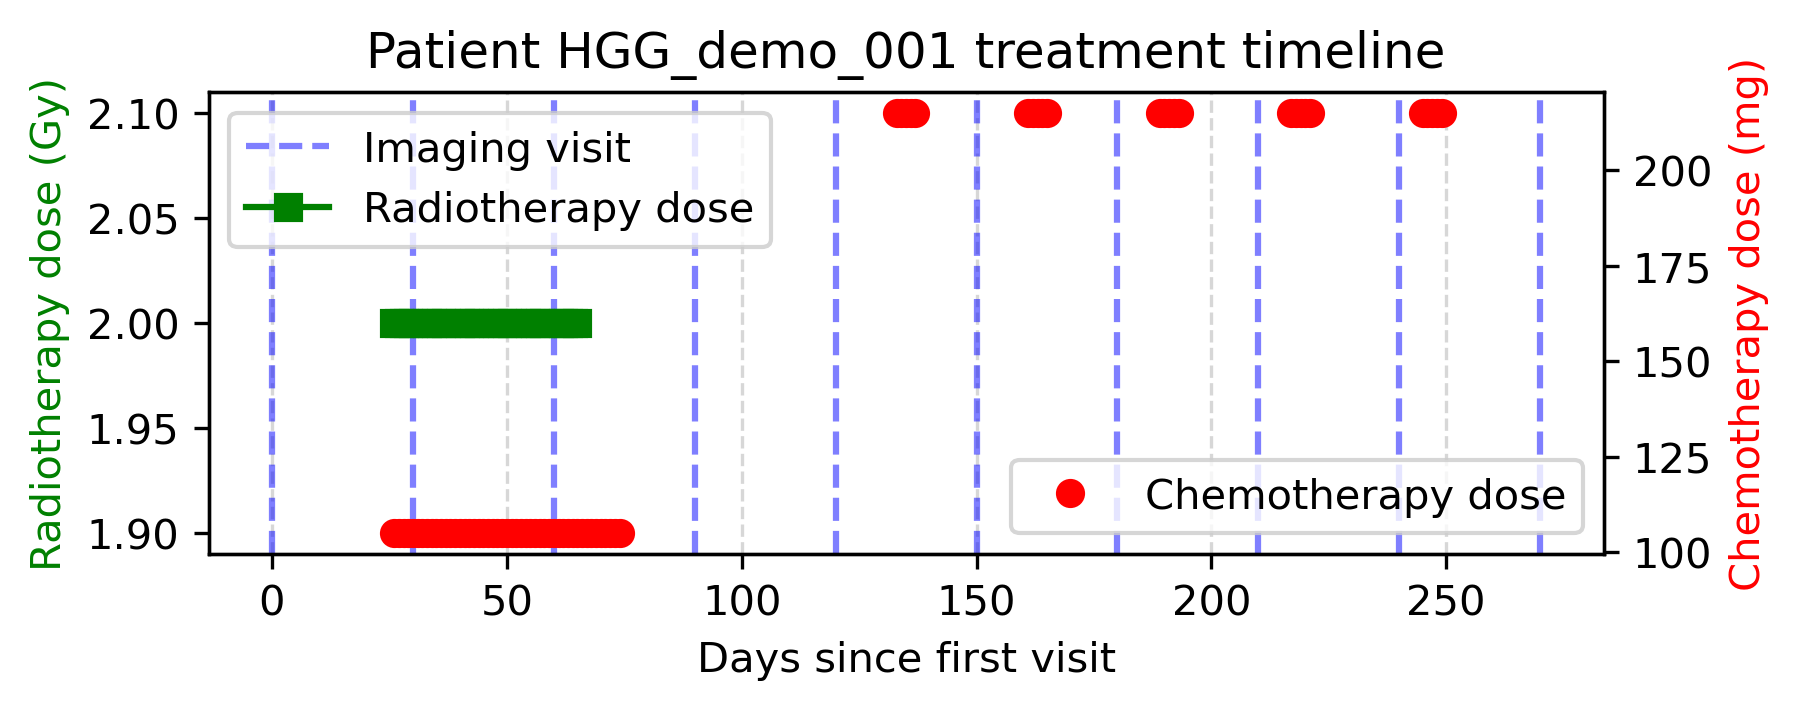

In [178]:
plot_patient_timeline(patient_data)

We can also plot a summary of the imaging data. Here you should verify that the images are aligned/registered, cropped appropriately, and that the anatomic (T1), apparent diffusion coefficient (ADC), and region-of-interest (ROI) images are as expected.

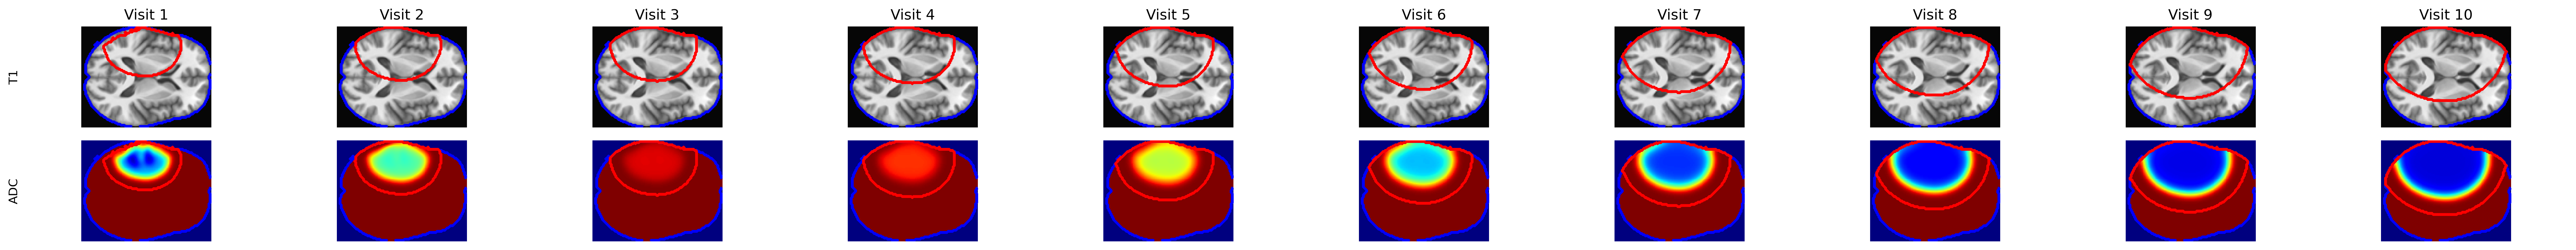

In [179]:
plot_imaging_summary(patient_data)

### Estimate cellularity from ADC
The tumor cellularity, $N(\mathbf{x},t_i)$ can be estimated from the ADC map according to the equation:
$$
N(\mathbf{x},t_i) = \frac{ADC_\text{w}-ADC(\mathbf{x},t_i)}{ADC(\mathbf{x},t_i)-ADC_\text{min}},
$$
This is implemented in the `ADC_to_cellularity`. Let's go ahead and convert the ADC maps for *all* visits into cellularity maps.

In [180]:
measured_cellularity_maps = [
    ADC_to_cellularity(
        visit.adc_image, visit.roi_enhance_image, visit.roi_nonenhance_image
    )
    for visit in patient_data.visits
]

---
## Step 2: Create Tumor Growth Model

### Preparing a Reaction-Diffusion model
$$
    \frac{\partial N(\textbf{x},t)}{\partial t} = \underbrace{\nabla \cdot \left( D \nabla N(\textbf{x},t) \right)}_{\text{invasion}} + \underbrace{k(\textbf{x})N(\textbf{x},t) \left(1 - \frac{N(\textbf{x},t)}{\theta} \right)}_{\text{logistic growth}}
    \quad \underbrace{- \sum_{i=1}^{n_{\text{CT}}} \sum_{j=1}^{T_i}\alpha_i C_i e^{-\beta_i\left( t-\tau_{i,j}\right)} N(\textbf{x},t)}_{\text{chemotherapy}}
$$
$$
    N(\textbf{x},t)_{\text{after}} = \underbrace{N(\textbf{x},t)_{\text{before}}e^{-a_{RT}d_{RT}(t)-\beta_{RT}d_{RT}(t)^2}}_{\text{radiotherapy}}   
$$

**Model Parameters:**
- $k$ : Proliferation Rate
- $d$ : Diffusivity
- $\theta$ : Carrying capacity
- $N(\textbf{x},0)$ : Initial condition for the tumor cellularity - we use the cellularity map derived from the first visit MRI data

In [181]:
k = torch.tensor(0.0408, requires_grad=True, device=device)
d = torch.tensor(0.0553, requires_grad=True, device=device)

# k = torch.tensor(0.05, requires_grad=True, device=device)
# d = torch.tensor(0.025, requires_grad=True, device=device)
theta = torch.tensor(1.0, requires_grad=False, device=device)
# [0.0243, 0.0428, 0.0512, 0.7024]
# [0.0553, 0.0408, 0.0429, 0.7489]

**Radiotherapy parameters:**
- $\alpha_{RT}$ : Radiosensitivity parameter, see `RadiotherapySpecification.alpha`
- $\beta_{RT}$: : Radiosensitivity parameter, often defined relative to $\alpha$, see `RadiotherapySpecification.alpha_beta_ratio`
- $d_{RT}$ : Radiotherapy dosage

Here we set up a `RadiotherapySpecification` for this patient. We use the treatment plan (times and dosages) that we loaded the patient json file, which are now stored within the `HGGPatientData` object:

In [182]:
rt = RadiotherapySpecification(
    # alpha=0.025,
    alpha=0.0429,
    alpha_beta_ratio=10,
    times=[r.time for r in patient_data.radiotherapy],
    doses=[r.dose for r in patient_data.radiotherapy],
)
# print(rt)

**Chemotherapy parameters:**

Note: Here we are working with only one chemotherapy drug, so $n_{\text{CT}}=1$
- $\alpha_{1}$ : Chemotherapy sensitivity parameter, see `ChemotherapySpecification.sensitivty`
- $\beta_{1}$: : Chemotherapy decay rate, see `ChemotherapySpecification.decay_rate`
- $C_{1}(d_{CT},t)$ : Chemotherapy drug concentration, which depends on the dosage given, and time since dosage was given.

We can set up a `ChemotherapySpecification` in a similar way, using the treatment plan (times and dosages) that we loaded from the patient json file, which are now stored within the `HGGPatientData` object:

In [183]:
ct = ChemotherapySpecification(
    # sensitivity=0.5,
    sensitivity=0.7489,
    decay_rate=9.2420,
    times=[c.time for c in patient_data.chemotherapy],
    doses=[c.dose for c in patient_data.chemotherapy],
)
# print(ct)

In [184]:
print(k.item())

0.040800001472234726

Finally, we can set up the `ReactionDiffusion3D` model object.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init

def invsig(x):
    return torch.log(x / (1 - x))

# Test whether the spatially varying k gives correct results
# This NN should return the constant k and lead to the same tumor growth
class k_net(nn.Module):
    def __init__(self, k):
        super(k_net, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        init.zeros_(self.fc1.weight)
        init.constant_(self.fc1.bias, invsig(k).item())

    def forward(self, x):
        return torch.sigmoid(self.fc1(x)).squeeze(-1)

# When used with calibration, we shouldn't use k_min and k_max (only for demonstration)
class spatialk_net(nn.Module):
    def __init__(self, hidden_dim=5, k_min=None, k_max=None):
        super().__init__()
        self.k_min = k_min
        self.k_max = k_max
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()  # ensures non-negativity
        )

    def forward(self, coords):
        # coords: Tensor of shape (num_voxels, 3)
        # returns: (num_voxels,)
        out = self.net(coords).squeeze(-1)
        if self.k_min is not None: # ensure that k(x) is in [k_min,k_max]
            out = self.k_min + (self.k_max - self.k_min) * out
        return out

# k_nn = k_net()
k_nn = spatialk_net(k_min=0.0, k_max=0.1)

torch.Size([90, 116, 36, 3])

torch.Size([90, 116, 36])

tensor(0.1561, grad_fn=<MeanBackward0>)

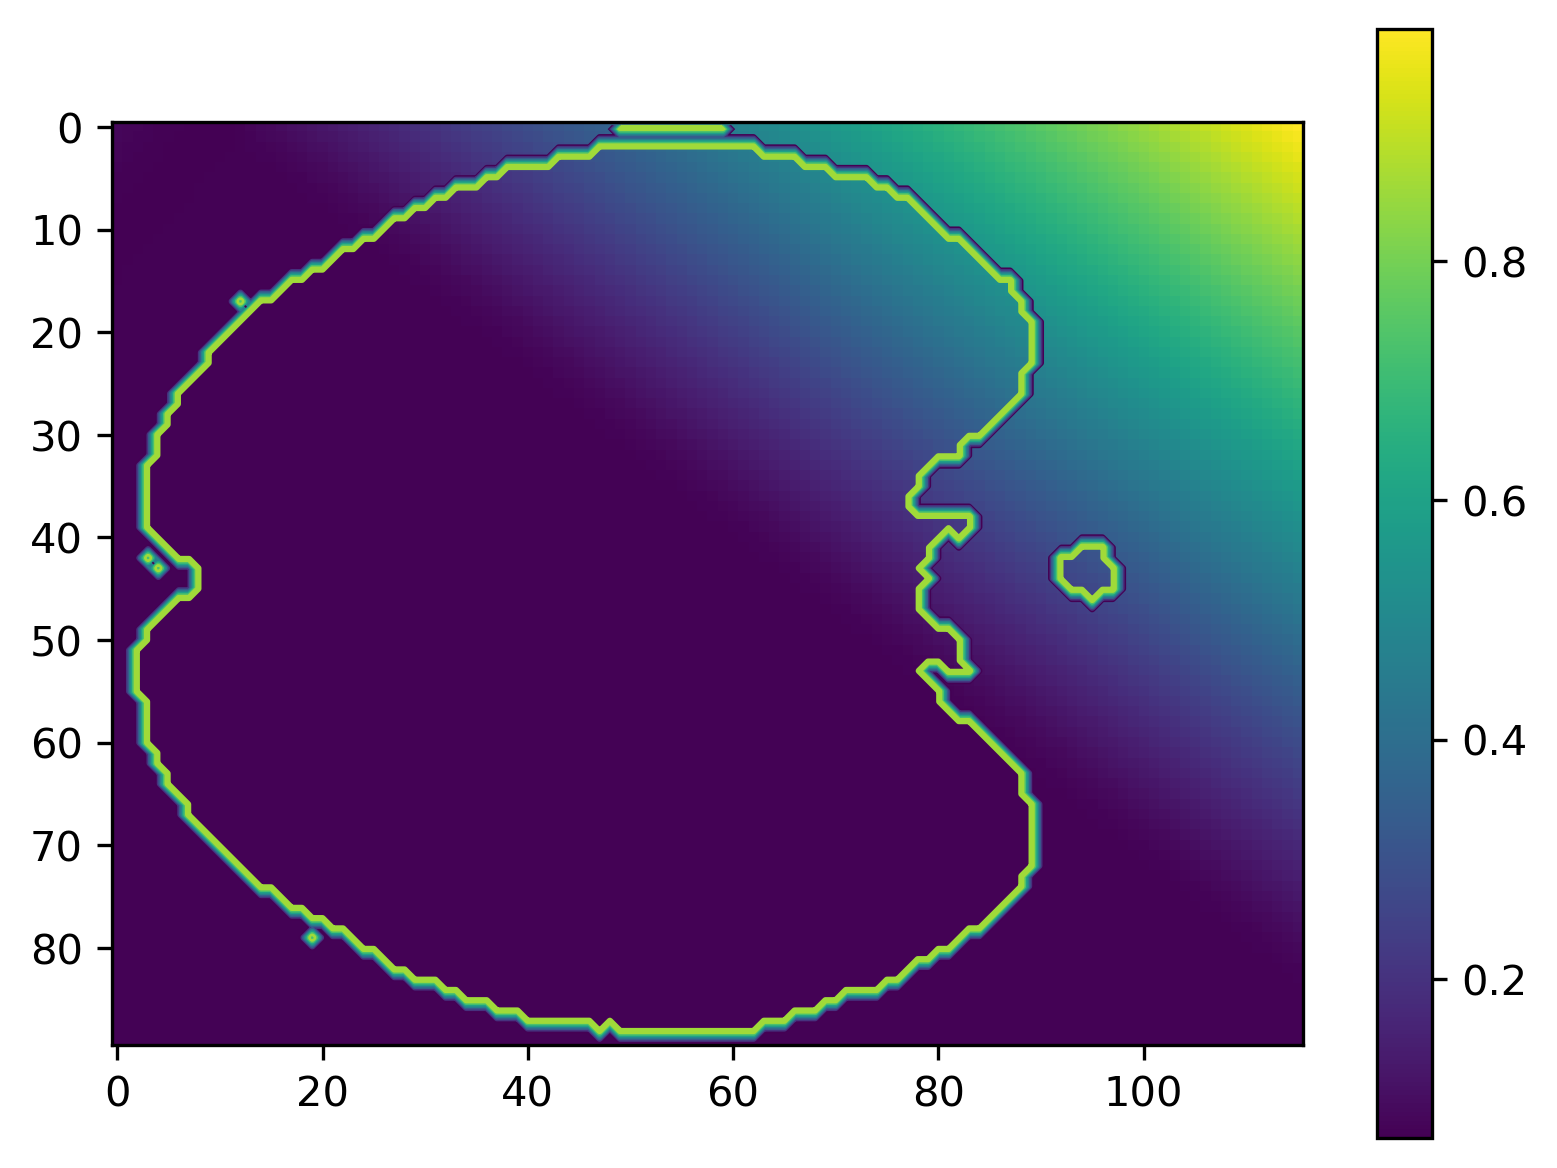

In [186]:
# 
mask_image = patient_data.brainmask_image
spacing=mask_image.spacing
# Create 1D tensors for each dimension
x_coords = torch.arange(0, mask_image.shape[0]*spacing.x, spacing.x)
y_coords = torch.arange(0, mask_image.shape[1]*spacing.y, spacing.y)
z_coords = torch.arange(0, mask_image.shape[2]*spacing.z, spacing.z)

# Use meshgrid to create all combinations of coordinates
x_grid, y_grid, z_grid = torch.meshgrid(x_coords, y_coords, z_coords, indexing='ij')
voxel_coords = torch.stack([x_grid, y_grid, z_grid], dim=-1)
print(voxel_coords.shape)
# voxel_coords = voxel_coords.reshape(-1,3)

k_tensor = k_nn(voxel_coords)
print(k_tensor.shape)

fig, ax = plt.subplots(1,1)
im = plt.imshow(k_tensor[:, :, k_tensor.shape[2] // 5].detach().numpy(), cmap="viridis")
plt.contour(patient_data.brainmask_image.array[:,:,k_tensor.shape[2] // 5])
plt.colorbar(im, ax=ax)
print(torch.mean(k_tensor))
plt.show()

In [187]:
model1 = ReactionDiffusion3D(
    k=k,
    d=d,
    theta=theta,
    patient_data=patient_data,
    initial_time=patient_data.visits[0].time,
    chemotherapy_specifications=[ct],
    radiotherapy_specification=rt,
)

model2 = ReactionDiffusion3D(
    k=k_nn,
    d=d,
    theta=theta,
    patient_data=patient_data,
    initial_time=patient_data.visits[0].time,
    chemotherapy_specifications=[ct],
    radiotherapy_specification=rt,
)

In [188]:
list(k_nn.parameters())

[Parameter containing:
 tensor([[-0.3093, -0.3886, -0.3699],
         [-0.4549, -0.5768,  0.4225],
         [-0.4852, -0.5562,  0.5524],
         [-0.5331, -0.1422, -0.1266],
         [-0.3530,  0.2798, -0.1783]], requires_grad=True),
 Parameter containing:
 tensor([ 0.4961,  0.5662,  0.0273,  0.3856, -0.3741], requires_grad=True),
 Parameter containing:
 tensor([[-0.3004, -0.3550, -0.1256, -0.1915,  0.1682],
         [-0.2434, -0.0611, -0.2839,  0.2799,  0.1713],
         [ 0.3316, -0.0049,  0.0939, -0.2046,  0.3944],
         [-0.3696,  0.1917, -0.0997, -0.4341,  0.1361],
         [ 0.3092, -0.3307,  0.1186, -0.0132, -0.1361]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2026,  0.3643, -0.2875, -0.3015, -0.2389], requires_grad=True),
 Parameter containing:
 tensor([[0.1244, 0.3067, 0.2807, 0.3154, 0.0965]], requires_grad=True),
 Parameter containing:
 tensor([-0.0502], requires_grad=True)]

In [189]:
print(list(model2.parameters()))
print(patient_data.brainmask_image.shape)

[
    Parameter containing:
tensor(0.0553, requires_grad=True),
    Parameter containing:
tensor([[-0.3093, -0.3886, -0.3699],
        [-0.4549, -0.5768,  0.4225],
        [-0.4852, -0.5562,  0.5524],
        [-0.5331, -0.1422, -0.1266],
        [-0.3530,  0.2798, -0.1783]], requires_grad=True),
    Parameter containing:
tensor([ 0.4961,  0.5662,  0.0273,  0.3856, -0.3741], requires_grad=True),
    Parameter containing:
tensor([[-0.3004, -0.3550, -0.1256, -0.1915,  0.1682],
        [-0.2434, -0.0611, -0.2839,  0.2799,  0.1713],
        [ 0.3316, -0.0049,  0.0939, -0.2046,  0.3944],
        [-0.3696,  0.1917, -0.0997, -0.4341,  0.1361],
        [ 0.3092, -0.3307,  0.1186, -0.0132, -0.1361]], requires_grad=True),
    Parameter containing:
tensor([ 0.2026,  0.3643, -0.2875, -0.3015, -0.2389], requires_grad=True),
    Parameter containing:
tensor([[0.1244, 0.3067, 0.2807, 0.3154, 0.0965]], requires_grad=True),
    Parameter containing:
tensor([-0.0502], requires_grad=True)
]

Shape3D(x=90, y=116, z=36)

---
## Step 3: Create a Solver object
Under the hood, our `ReactionDiffusion3D` model is actually a spatially discretized version of the reaction-diffusion PDE. Solving this semi-discrete model requires solving a large system of ordinary differential equations (ODEs). We do this via the `torchdiffeq` library, using the `TorchDiffEqSolver` object.

The `TorchDiffEqSolverOptions` object contains standard solver options such as the method to use (e.g. fourth-order Runge-Kutta or "rk4"), the timestep to use for solving, and whether to use the adjoint method for gradient computations (`False` would resort to automatic differentiation).

In [190]:
solver_options = TorchDiffEqSolverOptions(
    step_size=timedelta(days=0.5),
    use_adjoint=True,
    device=device,
    method="rk4",
)

solver1 = TorchDiffEqSolver(model1, solver_options)

solver2 = TorchDiffEqSolver(model2, solver_options)

---
## Step 4: Make a prediction
We are now ready to leverage our model and solver to make a prediction of tumor growth and response to treatment.

We will use the measured cellularity map from the first patient visit (`measured_cellularity_maps[0]`) as an initial condition for the model, and make a prediction from the first visit date until the final visit date: a total of `225 days`. We will output the solution every `0.5 days`.

In [191]:
timepoints = daterange(
    patient_data.visits[0].time, patient_data.visits[-1].time, timedelta(days=0.5)
)
u0 = torch.from_numpy(measured_cellularity_maps[0].array)

times, predicted_cellularity_maps = solver1.solve(timepoints=timepoints, u_initial=u0)

times2, predicted_cellularity_maps2 = solver2.solve(timepoints=timepoints, u_initial=u0)

Forward Simulation: [1996-11-15 00:00:00 to 1997-08-12 00:00:00 with timestep 0.50 days]:   0%|          | 0.0…

Forward Simulation: [1996-11-15 00:00:00 to 1997-08-12 00:00:00 with timestep 0.50 days]:   0%|          | 0.0…

### Visualize the predicted tumor growth
Let's plot our solution. We will use the Total Tumor Cell Count (TCC) as a simple measure of the tumor size:
$$
\text{TTC}(t) = \sum_\mathbf{i} \mathbf{N}_i(t)\theta_{\text{voxel}}
$$ 
Here $\theta_{\text{voxel}}$ is the number of cells that fit into an image voxel.

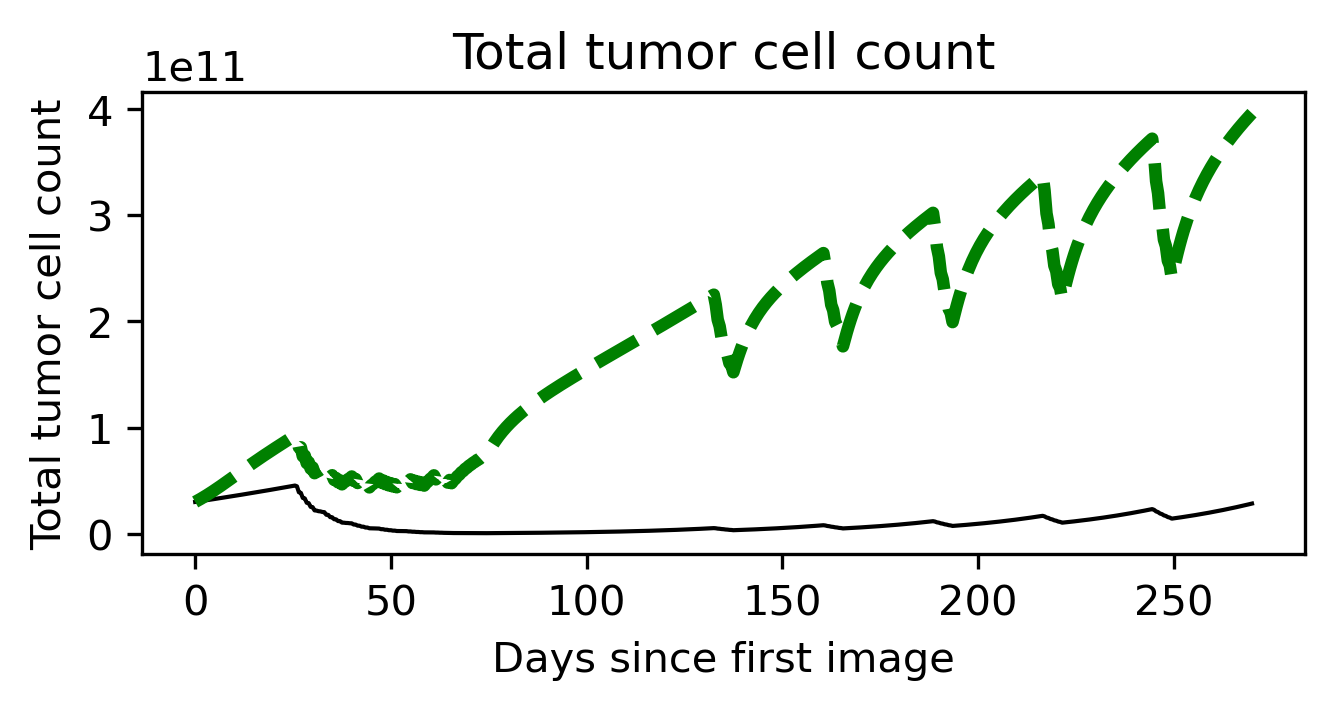

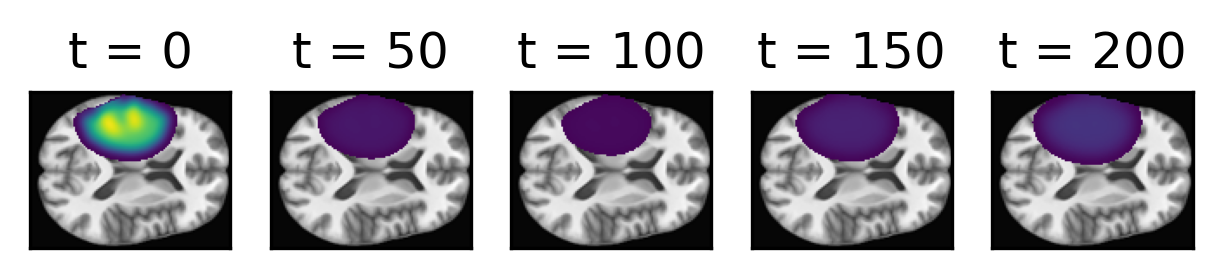

In [192]:
# brain_mask = torch.from_numpy(patient_data.brainmask_image.array)

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
plot_predicted_TCC(predicted_cellularity_maps, timepoints, ax=ax)
plot_predicted_TCC(predicted_cellularity_maps2, timepoints, color='g', linestyle="--", linewidth="3.0",ax=ax)

fig, axes = plt.subplots(1, 5, figsize=(5, 2))
for i, t in enumerate([0, 50, 100, 150, 200]):
    time_days = np.array([days_since_first(t, timepoints[0]) for t in timepoints])
    t_idx = np.where(time_days == t)[0][0]
    plot_cellularity_map(
        predicted_cellularity_maps[t_idx], patient_data, time=t, ax=axes[i]
    )
plt.show()

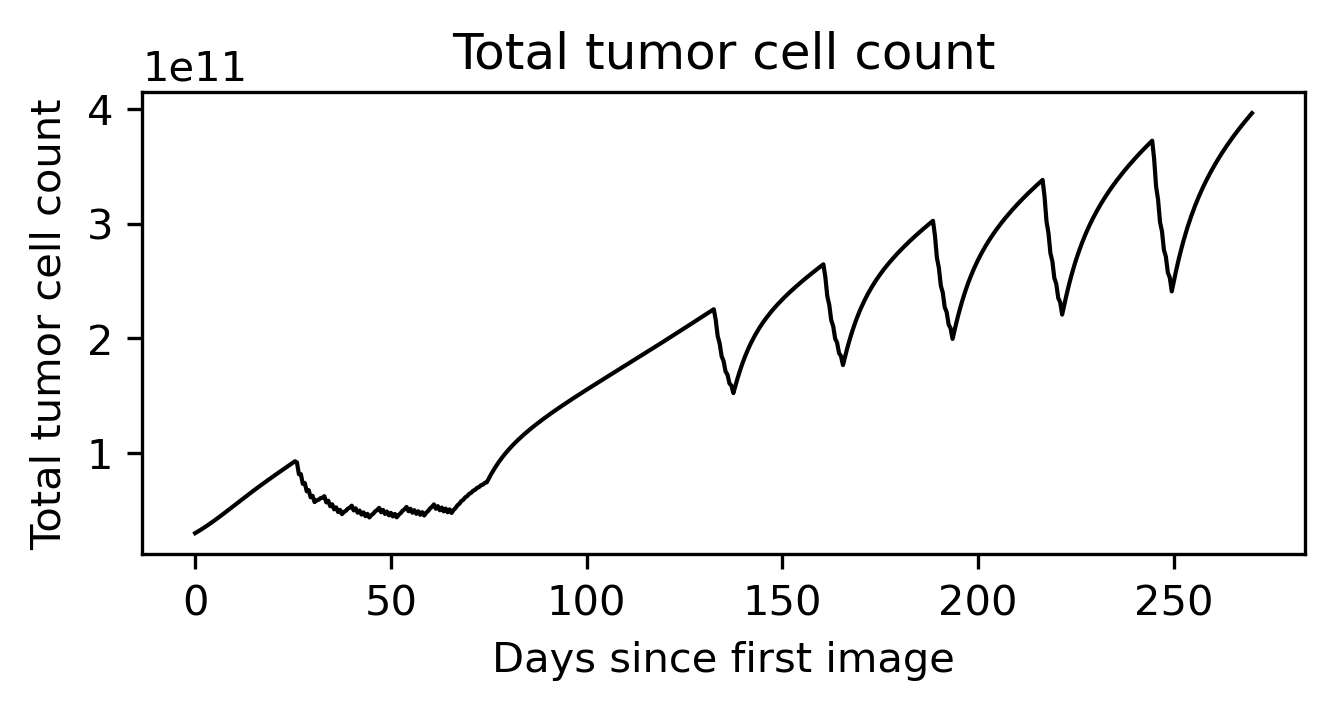

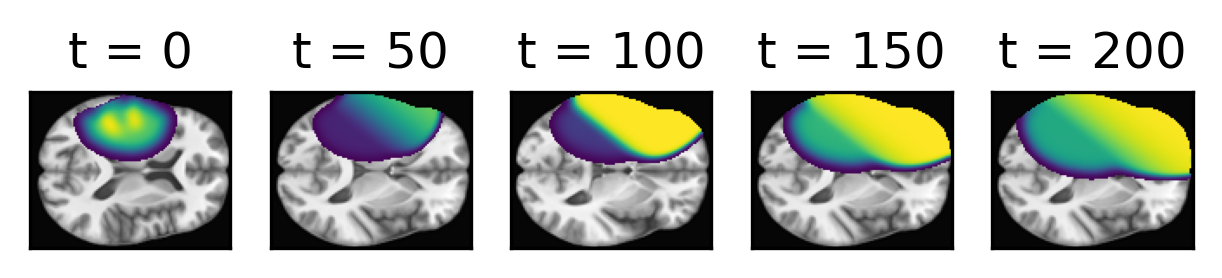

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
plot_predicted_TCC(predicted_cellularity_maps2, timepoints, ax=ax)

fig, axes = plt.subplots(1, 5, figsize=(5, 2))
for i, t in enumerate([0, 50, 100, 150, 200]):
    time_days = np.array([days_since_first(t, timepoints[0]) for t in timepoints])
    t_idx = np.where(time_days == t)[0][0]
    plot_cellularity_map(
        predicted_cellularity_maps2[t_idx], patient_data, time=t, ax=axes[i]
    )
plt.show()

---
## Step 5 (Optional): Compute final cell count and its gradient
Let's compute $\text{TCC}_{final}$ explicitly, and then also compute it's gradient with respect to some of the model parameters, $\frac{\partial \text{TCC}_{final}}{\partial k},  \frac{\partial \text{TCC}_{final}}{\partial d}$

In [194]:
# carrying_capacity = compute_carrying_capacity(patient_data.brainmask_image)
# final_tumor_cell_count = compute_total_cell_count(
#     predicted_cellularity_maps[-1], carrying_capacity
# )
# print(final_tumor_cell_count)

To compute the gradients, we need to run a backwards (adjoint) solve. We can do this using the standard `PyTorch` approach of calling `.backward()` on the final tumor_cell_count to populate the gradients.

In [195]:
# final_tumor_cell_count.backward()

# # k_grad = model.k.grad
# # print(f"Gradient of the final TCC w.r.t proliferation rate: {k_grad}")

# d_grad = model.d.grad
# print(f"Gradient of the final TCC w.r.t diffusion rate: {d_grad}")

In [196]:
# print(model.k_tensor.grad)
# print(list(k.parameters())[0].grad)


---
## Step 6: Compare the model prediction to patient data
Let's compare how our model prediction based on only the first MRI visit compares with the data we have from subsequent visits:

In [197]:
# # plot TCC vs. time for predictions and measurements
# fig, ax = plt.subplots(1, 1, figsize=(5,2))
# plot_predicted_TCC(predicted_cellularity_maps, timepoints, ax=ax)
# plot_measured_TCC(
#     [m.array for m in measured_cellularity_maps],
#     [v.time for v in patient_data.visits],
#     ax=ax,
# )
# ax.legend(["predicted", "measured"]);

# # plot cellularity maps for predictions and measurements
# fig, axs = plt.subplots(2, len(patient_data.visit_days[::2]), figsize=(5,2))
# for i, t in enumerate(patient_data.visit_days[::2]):
#     time_days = np.array([days_since_first(t, timepoints[0]) for t in timepoints])
#     t_idx = np.where(time_days == t)[0][0]
#     plot_cellularity_map(
#         predicted_cellularity_maps[t_idx], patient_data, time=t, ax=axs[0,i]
#     )
#     plot_cellularity_map(
#         torch.tensor(measured_cellularity_maps[2*i].array), patient_data, time=t, ax=axs[1,i]
#     )
# axs[0,0].set_ylabel('Predicted')
# axs[1,0].set_ylabel('Measured');

Not very good! We see that our model is significantly under-predicting the size/intensity of the tumor. 
- Perhaps this patient has a more aggressive tumor? We could try increasing the tumor proliferation rate, $k$, or the diffusion rate $d$?
- Perhaps they are not responding to treatment as well as we thought? We could try reducing the radiosensitivity or chemosensitivity parameters, $\alpha$?

---
## Step 7: Calibrate the model to patient data via numerical optimization
Rather than a trial-and-error approach, we can instead leverage numerical optimization to calibrate our model parameters to better match the observed data.

We will use the Levenberg-Marquardt (LM) algorithm ([Wikipedia Link](https://en.wikipedia.org/wiki/Levenberg–Marquardt_algorithm)). This algorithm will seek to minimize the sum-of-squares difference between our predicted cellularity fields and the measured cellularity fields., i.e.,

$$
\sum_{v=0}^{\texttt{N\_visits}} \sum_{j=0}^{\texttt{N\_voxels}} (N_j(t_v) - \hat{N}_j(t_v))^2
$$
where $t_v$ is the time step corresponding to visit $v$, $N_j$ and $\hat{N}_j$ are the discretized predicted and measured (respectively) cellularity values at voxel $j$.

First we choose how many imaging visits to calibrate to by setting `n_calibration_targets`, and picking out the corresponding solutions and timepoints:

In [198]:
# # How many imaging dates do we want to try and match
# n_visits_calibration = 5  # *Including* the initial visit

# target_timepoints = [visit.time for visit in patient_data.visits[:n_visits_calibration]]
# target_solution = torch.stack(
#     tuple(
#         [
#             torch.from_numpy(m.array)
#             for m in measured_cellularity_maps[: n_visits_calibration]
#         ]
#     )
# )

#### Create an Optimizer object
Finally, we set up a Levenberg-Marquardt (LM) optimizer object. We can set various algorithm hyperparameters via the `LMOptions()` object, or stick with the defaults. We also set an initial guess for the model parameters, as well as upper and lower bounds on their values. Finally, we pass the target solution values, and our `update_model_and_predict` function for the optimizer to use.

In [199]:
# criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(k.parameters(), lr=0.0001, momentum=0.9)
# _, predicted_cellularity_maps = solver.solve(timepoints=target_timepoints, u_initial=u0)

# loss = criterion(predicted_cellularity_maps, target_solution)

# # Backward pass
# loss.backward()

# # Update parameters
# optimizer.step()


In [200]:

# print(list(model.parameters()))
# # print(list(model.k.parameters()))

#### Run the optimization
We are now ready to run the LM algorithm for a chosen number of steps.

Consider running somewhere between `5` and `30` iterations, with more iterations providing a better quality final solution (at the cost of longer runtime).

In [201]:
# # Run optimization for n_iter steps
# n_iter = 20

# for i in range(n_iter):
#     print("Optimization Step: " + str(i+1) +"/"+str(n_iter))
#     optim.step()

# best_parameters = optim.parameters[-1]
# print("Best parameters: ", best_parameters)

#### Visualize the optimization iterations
Let's visualize the progress of the optimizer by visualizing solutions at every `n_opt_viz` optimization steps.

In [202]:
# n_opt_viz = 2
# sols = []
# for params in optim.parameters[::n_opt_viz]:
#     predicted_cellularity_maps = update_model_and_predict(params, timepoints)
#     sols.append(predicted_cellularity_maps)

Now we plot the solutions visited by the optimizer, along with the corresponding loss (sum-of-squares error) values:

In [203]:
# fig, ax =plt.subplots(1,1, figsize=(5,2))
# plot_calibration_iter(
#     sols, carrying_capacity, timepoints, measured_cellularity_maps, patient_data, t_calibration_end=target_timepoints[-1], ax=ax
# )

# fig, ax =plt.subplots(1,1, figsize=(5,2))
# plot_loss(torch.tensor(optim.error), ax=ax)

For this particular dataset, we know what the ground-truth parameter values are since we used them to generate the data! Of course, in a real scenario you wouldn't know what the "true" parameters are. In fact, the data might not exactly match the model for _any_ value of the parameters.

Ideally, our calibrated parameter values will be close to these, so let's compute the relative error in each parameter:

In [204]:
# true_parameters = torch.tensor((0.1, 0.05, 0.05, 0.2))
# final_parameters = optim.parameters[-1]


# def relative_error(estimate, truth):
#     return (100*abs(truth-estimate)/truth).round(decimals=4)


# print(f"Error in k: {relative_error(final_parameters[0], true_parameters[0])}%")
# print(f"Error in d: {relative_error(final_parameters[1], true_parameters[1])}%")
# print(f"Error in alpha: {relative_error(final_parameters[2], true_parameters[2])}%")
# print(f"Error in ct_sens: {relative_error(final_parameters[3], true_parameters[3])}%")

## Step 8: Predict patient response under alternative treatment plan
Now that we have a calibrated digital twin model, we can use it to predict how this particular patient might respond to different treatment plans.

Recall that we calibrated the digital twin model to imaging visits acquired _prior to adjuvant chemotherapy_. A remaining treatment decision might be the adjuvant chemotherapy dosages and schedule. We would expect that increasing the dosage will lead to greater tumor control, but note that higher dosages are also likely to lead to greater toxicity. Let's explore the tradeoff using our calibrated digital twin model!

First, we'll define a function that updates the remaining chemotherapy doses based on a given *total* chemotherapy dosage.

In [205]:
# def update_ct_total_dose(ct : ChemotherapySpecification, total_dose : float):
#     current_total_dose : float = np.sum(np.array(ct.doses))
#     additional_dose = total_dose - current_total_dose

#     adjuvant_total_dose = np.sum(ct.doses[49:])
#     dose_multiplier = (additional_dose+adjuvant_total_dose) / adjuvant_total_dose
#     ct.doses[49:] = [d*dose_multiplier for d in ct.doses[49:]]
#     return ct

Now let's predict the tumor response for a range of total dosages, and plot the results:

In [206]:
# sols = []
# candidate_doses = [30, 40, 50, 60, 70]

# fig, ax = plt.subplots(1, 1, figsize=(5, 2))
# for ct_total_dose in candidate_doses:
#     update_ct_total_dose(ct, ct_total_dose)
#     solver.model.chemotherapy_specifications = [ct]
#     print(f"Running forward solve with total dose = {ct_total_dose}")
#     times, predicted_cellularity_maps = solver.solve(timepoints=timepoints, u_initial=u0)
#     plot_predicted_TCC(predicted_cellularity_maps, timepoints, ax=ax, alpha= 0.25 + 0.75*(ct_total_dose-min(candidate_doses))/(max(candidate_doses)-min(candidate_doses)))

# ax.legend(["Total dose: "+str(d) for d in candidate_doses]);

---
## Conclusion 

Here we have demonstrated the core workflows of `TumorTwin`. We have shown how to load in a patient dataset, create a tumor growth model, create a solver for the model, make predictions with the model under various parameters and treatments, and calibrate the model to patient data.

---
## Discussion Questions
__Modeling__
- What effects could we add to the reaction-diffusion model?

__Calibration__
- How much data is needed for calibration?
- How does the timing of the imaging visits influence the calibration performance?
- Under what conditions might the calibration be unable to uniquely identify all the parameters?
---